## Identifying road segments with potential safety hazard

#### Introduction

Every day there are more vehicules in our cities, not only because of the population increasing but because of the number of vehicules per capita. This situation provokes some problems in our daily lives, specially two:

 - High air pollution concentration, which results in healthy problems
 - Lost of time because of the traffic jam.

So, in this repository we will abroad how to solve these situations, which are the main reasons and consequencies, and we will propose practical ideas that can help to change the city transportation model. Everybody have to take part of them, including governments, enterprises, associations and people.

Our team have chosen the challenge number 4, which lays out daily roads state. The goal of this challenge is to detect and understand conflictives situations in the main roads, such as traffic jam. The reason we choose this track is because we belive there is so much to do on this area, and it is a problem for each big city in the world and the solutions are quite similar in every country.

The main reasons makes people move around are leisure and necessitities, i.e. bar & restaurants, cultural events, work, hospitals, shopping & alimentation, schools & universities.

In that context, we will propose how to reduce traffic levels by not touching people comfort. Solutions for everybody, so not expensive, and really accesible and practical for the society, ready to implement right now.

The database is indexed by road segment. Including daily intensity, speed average, 1st, 3th and median speed quantiles, speed limit, func class, which indicates the type of road and the variable geometry, which includes coordenates for every segment. Data are between April
2019 and March 2020.

#### Data importing & cleaning

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install geopandas
import geopandas as gpd
import json 
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim

import seaborn as sns
sns.set()
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
!pip install kneed
from kneed import KneeLocator
import scipy.cluster.hierarchy as sch

!pip install keplergl
from keplergl import KeplerGl

import plotly.graph_objects as go

In [116]:
data_ini=gpd.read_file('./sample_data/m_risk_prfile.geojson')
data_ini = data_ini.rename(columns = {'Link_ID':'link_id',
                              'Daily_Aver':'daily_intensity',
                              'Average_Ve':'speed_avg',
                              'Median_of_':'speed_median',
                              'First_Quar':'speed_1st_qrt',
                              'Third_Quar':'speed_3th_qrt',
                              'Func_Class':'func_class',
                              'Speed_Cat':'speed_cat'})#.round(2)
data_ini = data_ini[['link_id','daily_intensity','speed_avg','speed_median','speed_1st_qrt','speed_3th_qrt','func_class','speed_cat','geometry']]

# speed_lim_cat variable creation
sp = {'speed_cat' : [1, 2, 3, 4, 5, 6, 7, 8 ],
      'speed_lim' : [150, 130, 100, 90, 70, 50, 30, 11],
      'speed_lim_cat' : ["fast", "fast", "fast", "med", "med", "slow", "slow", "slow"]}
speed_lim = pd.DataFrame(sp)
data = data_ini.merge(speed_lim, on = "speed_cat", how = "left")

funccional_class={1:'These roads are meant for high volume, maximum speed traffic between and through major metropolitan areas. There are very few, if any, speed changes. Access to this road is usually controlled.',
                  2:'These roads are used to channel traffic to Main Roads (FRC1) for travel between and through cities in the shortest amount of time. There are very few, if any speed changes.',
                  3:'These roads interconnect First Class Roads (FRC2) and provide a high volume of traffic movement at a lower level of mobility than First Class Roads (FRC2).'}

speed_cat={1:'>130 km/h',
           2:'101-130 km/h',
           3:'91-100 km/h',
           4:'71-90 km/h',
           5:'51-70 km/h',
           6:'31-50 km/h',
           7:'11-30 km/h',
           8:'<11 km/h'}
# asigno a cada una de las columnas su valor mediante map
data['road_type']=data['func_class'].map(funccional_class)
data['speed_type']=data['speed_cat'].map(speed_cat)

data.head(5)


,link_id,daily_intensity,speed_avg,speed_median,speed_1st_qrt,speed_3th_qrt,func_class,speed_cat,geometry,speed_lim,speed_lim_cat,road_type,speed_type
0,80216819,6224.778569,45.208716,44.464286,28.000000,59.00,2,6,"MULTILINESTRING ((-9.16402 38.77030, -9.16389 ...",50,slow,These roads are used to channel traffic to Mai...,31-50 km/h
1,80216858,2236.054168,79.563308,82.750000,71.750000,93.25,2,4,"MULTILINESTRING ((-9.16645 38.74274, -9.16638 ...",90,med,These roads are used to channel traffic to Mai...,71-90 km/h
2,80216859,2138.725039,65.955069,67.333333,61.000000,75.00,3,6,"MULTILINESTRING ((-9.16645 38.74274, -9.16637 ...",50,slow,These roads interconnect First Class Roads (FR...,31-50 km/h
3,80216860,2201.335041,47.533911,44.000000,26.900000,74.00,3,6,"MULTILINESTRING ((-9.16588 38.74370, -9.16568 ...",50,slow,These roads interconnect First Class Roads (FR...,31-50 km/h
4,80216867,2102.610278,51.375291,53.250000,45.333333,59.00,3,6,"MULTILINESTRING ((-9.16472 38.74478, -9.16487 ...",50,slow,These roads interconnect First Class Roads (FR...,31-50 km/h


Here we have created one variable, speed_lim which indicates the maximum velocity allowed on the road segment, then speed_lim_cat, with 3 values, "Slow", "Med" and "Fast". Roads which their upper limit is 50Km/h is considered "Slow", from 50 to 90Km/h are named as "Med", finally higher than 90Km/h are the "Fast" segments.

On the other hand we have included labels for the future maps we will draw. For the variables speed_cat and func_class.

After some analysis we conlcuded that we have to eliminate some observations because we consider them as outliers. We only keep segments which their speed on the first quartile is lower than the speed limit and the 3th quartile is under 150.

In [117]:
# We clean outliers
# We consider outliers every segment which their Q1 speed is higher than their speed limit, also negative Q1s
data = data.query("0 < speed_1st_qrt < speed_lim ").query("0 < speed_3th_qrt < 150 ")
data.shape

(32384, 13)

Below we present the speed distribution of the first and third quartiles. These two speed variables will be used to determine traffic jam indicators.

In [ ]:
data[["speed_1st_qrt","speed_lim_cat"]].groupby(["speed_lim_cat"]).describe(percentiles=[0.1, 0.25, 0.50, 0.75, 0.9])

speed_1st_qrt                        ...                          
                      count       mean        std  ...    75%    90%         max
speed_lim_cat                                      ...                          
fast                 6925.0  76.797020  22.021121  ...  93.75  101.0  127.750000
med                  6827.0  47.187602  15.727761  ...  58.00   68.0   89.333333
slow                18632.0  28.321515  11.011758  ...  37.00   43.5   49.916667

[3 rows x 10 columns]

In [ ]:
data[["speed_3th_qrt","speed_lim_cat"]].groupby(["speed_lim_cat"]).describe(percentiles=[0.1, 0.25, 0.50, 0.75, 0.9])

speed_3th_qrt                         ...                     
                      count        mean        std  ...    75%    90%    max
speed_lim_cat                                       ...                     
fast                 6925.0  106.536934  17.555516  ...  120.0  127.0  149.0
med                  6827.0   71.718817  17.204331  ...   83.5   93.5  138.0
slow                18632.0   50.787999  13.414178  ...   58.0   66.0  145.0

[3 rows x 10 columns]

### Cluster Analysis

In order to help local governments to analyse which are their congested areas or which are in the limit to be, we define what a traffic jam is. So, we propose which minimum speed per segment is required to not be considered as traffic jam. That is, if the speed value is under that limit, we consider the segment as congested.

Both first and third quartiles have been studied to determine which are those limits. Third quartile analysis gave us the key to understand when a segment was slower than waited the most part of the day. Meanwhile, First quartile analysis indicates which segments are conflictive in special moments of the day, such as the morning or the evenning. After several tests we have considered that first quantile was more significative.

First of all, we developpe a Cluster analysis to make groups of road segments depending on their speed. Then regarding on their average we determine which ones are more conflictives. Next by calculating the range (min and max) we determine the conditions (intervals) a traffic jam has.

Due to the several differences between road speeds we have separated them into the three groups defined above (speed_limit_cat). So we build three Cluster analysis. Then we will concatenate.

One of the most important steps before to start to build a Cluster analysis is to know how many groups we will need. For that, we have developped the below function which determines the optimal number of cluster by watching the Squared Standard Error (SSE). It tests the same model with different number of cluster, then it compares if the decreasing of the SSE for each new model with a new cluster is significative.



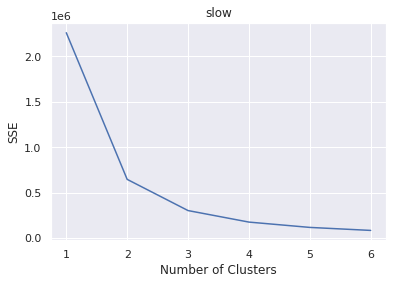

slow : recommended number of cluster =  2


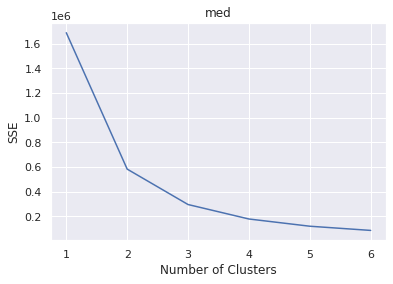

med : recommended number of cluster =  2


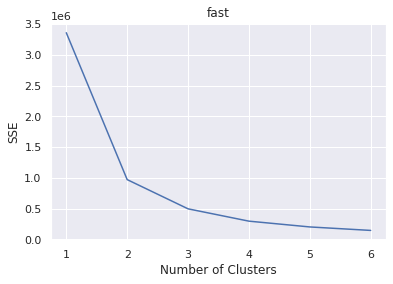

fast : recommended number of cluster =  2


In [ ]:
sseq1_slow  =[]; sseq1_med  = [];sseq1_fast  = []; 

def elbow_clus(list_out,list_in, db, road_type):
    for i in range(1,7):
        list_out.append(KMeans(init="random",n_clusters=i,n_init=10,max_iter=300,random_state=None).fit(db[list_in]).inertia_)
    
    plt.plot(range(1, 7), list_out)
    plt.xticks(range(1, 7))
    plt.title (road_type)
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    kl = KneeLocator(range(1, 7), list_out, curve="convex", direction="decreasing")
    print(road_type,": recommended number of cluster = ", kl.elbow)  
    
elbow_clus(sseq1_slow,['speed_1st_qrt'], data[data["speed_lim_cat"] == "slow"], "slow")
elbow_clus(sseq1_med,['speed_1st_qrt'], data[data["speed_lim_cat"] == "med"], "med")
elbow_clus(sseq1_fast,['speed_1st_qrt'], data[data["speed_lim_cat"] == "fast"], "fast")



The grapfics above show the SSE for each model. We can see that the SSE decreases when we add a new cluster. So higher the number of clusters lower the error. But a model with too many clusters is not understandable and could be overfitted. So elbow function indicates us when the reduction of SSE is not significative anymore.

In our case the best models, of each speed limit sample, should contain 2 clusters.

Next, we cluster the three samples.

In [118]:
# Clustering
data_slow = data[data["speed_lim_cat"] == "slow"]
data_med = data[data["speed_lim_cat"] == "med"]
data_fast = data[data["speed_lim_cat"] == "fast"]

ward = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')

ward_slow = ward.fit_predict(data_slow[["speed_1st_qrt"]])
data_slow["ward_q1"] = ward_slow

ward_med = ward.fit_predict(data_med[["speed_1st_qrt"]])
data_med["ward_q1"] = ward_med

ward_fast = ward.fit_predict(data_fast[["speed_1st_qrt"]])
data_fast["ward_q1"] = ward_fast


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In the three samples, when cluster variable (ward_q1) is equal to 0 means that the traffic level is high so, in order to make the variable more readable we create two values for this new variable, which indicates if it is high or low the congestion of each segment.

In [ ]:
data_slow.loc[data_slow["ward_q1"] == 0, 'traffic_level'] = 'high'
data_slow.loc[data_slow["ward_q1"] == 1, 'traffic_level'] = 'low'

data_med.loc[data_med["ward_q1"] == 0, 'traffic_level'] = 'high'
data_med.loc[data_med["ward_q1"] == 1, 'traffic_level'] = 'low'

data_fast.loc[data_fast["ward_q1"] == 0, 'traffic_level'] = 'high'
data_fast.loc[data_fast["ward_q1"] == 1, 'traffic_level'] = 'low'


In [120]:
# Then we have concatenate the three samples
data_clus = pd.concat([data_slow, data_med, data_fast], ignore_index=True)
#data_clus.head(5)

In the next step, we want to know empiricly what is a traffic jam. So we analyse the distribution by the cluster variable for each group,  specially regarding on the Max value, which indicates the upper traffic level limit. As we see for the "Slow" roads, 35km/h is the threshold for traffic jam, so every slow-segment which its first quartil is under 35km/h we can consider it as congested. For "Med" roads, threshold is 53km/h, and for "Fast" ones, is 77km/h.


In [ ]:
# which cluster is the fastest and lowest, speed_lim mean is similar inside the groups
print("SLOW ") 
data_slow[["speed_1st_qrt","speed_lim","traffic_level"]].groupby("traffic_level").agg(['mean','min','max'])

# segments with high traffic level, roll in average less than half of the limit speed

SLOW 


speed_1st_qrt                       speed_lim        
                       mean       min        max       mean min max
traffic_level                                                      
high              22.693259   0.50000  35.444444  49.636946  30  50
low               41.687221  35.47619  49.916667  50.000000  50  50

In [ ]:
print("MED ")
data_med[["speed_1st_qrt","speed_lim","traffic_level"]].groupby("traffic_level").agg(['mean','min','max'])


MED 


speed_1st_qrt                        speed_lim        
                       mean        min        max       mean min max
traffic_level                                                       
high              38.190372   1.000000  53.162500  85.052141  70  90
low               64.666273  53.333333  89.333333  86.000000  70  90

In [ ]:
print("FAST ")
data_fast[["speed_1st_qrt","speed_lim","traffic_level"]].groupby("traffic_level").agg(['mean','min','max'])


FAST 


speed_1st_qrt                      speed_lim          
                       mean        min     max        mean  min  max
traffic_level                                                       
high              56.255494   6.000000   77.75  116.915309  100  130
low               93.155641  77.828571  127.75  126.280156  100  130

Also we regard the speed limit variable distribution on each group. It is remarkable that in every road type, speed limit average is similar for both groups. So First Quartile average speed is independent of the speed limit.

Now, we want to consider the daily intensity variable, which explains the number of vehicules that run daily on every road. As we see in the table and graph below there is not big differences by traffic level, that's the intensity it is independent of traffic. The condition higher the intensity higher the trafic jam is not necessary true.

The graphs represent fast and slow roads intensity colored by traffic level. Except the very high values the gross part of both groups have the same intensity values.

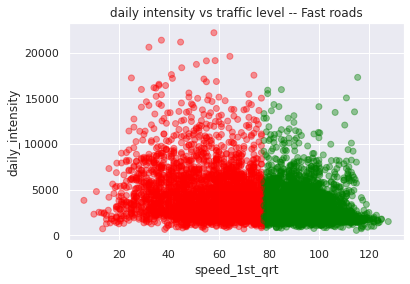

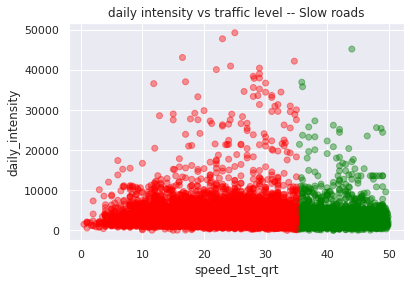

daily_intensity               ...                           
                        count         mean  ...          90%           max
traffic_level                               ...                           
high                  20688.0  3521.425490  ...  6071.929015  49309.806935
low                   11696.0  3134.023986  ...  5233.051360  45240.005415

[2 rows x 10 columns]

In [ ]:
colors = {"low":'green', "high":'red'}
data_clus_f = data_clus[data_clus["speed_lim_cat"] == "fast"]
#plt.figure(figsize=(14, 8))
plt.ylabel("daily_intensity")
plt.xlabel("speed_1st_qrt")
plt.title('daily intensity vs traffic level -- Fast roads')
plt.scatter(data_clus_f["speed_1st_qrt"],data_clus_f["daily_intensity"], c=data_clus_f["traffic_level"].map(colors), alpha=0.4)
plt.show()

data_clu_s = data_clus[data_clus["speed_lim_cat"] == "slow"]
plt.ylabel("daily_intensity")
plt.xlabel("speed_1st_qrt")
plt.title('daily intensity vs traffic level -- Slow roads')

plt.scatter(data_clu_s["speed_1st_qrt"],data_clu_s["daily_intensity"], c=data_clu_s["traffic_level"].map(colors), alpha=0.4)
plt.show()

data_clus[["daily_intensity","traffic_level"]].groupby("traffic_level").describe(percentiles=[0.1, 0.25, 0.50, 0.75, 0.9])

### Heat Map

From now we already know which segments run slower than expected. Let's paint them in a Heatmap, in order to analyse graphicly where they are.

We use kepler library to represent the conflictive areas in the map. Thanks to that technique we can locate easly which roads are the most congested. The red segments represent the traffic level equals to high, as we have define before, based on the cluster analysis.

If the reader wishs, it is possible to **download** an HTML and to play with filters zoom and city ☞ [here](https://drive.google.com/file/d/1H0MnZKhzSBlt1RvAKQF6v0CYWu1Qc9AE/view?usp=sharing)



```
#Create a basemap 
map= KeplerGl(height=800, weight = 500, data={'data_clus':df})
```


In the first map we show Lisbon. There are three big areas which have congested segments.
 - Bridges entrances, both "25 abril" and "Vasco de Gama" bridges suffer bottlenecks every day in their entrances. Situation is more critical from Setubal's side, because of the tolls. In Almada's toll, first quartile speed is under 30 Km/h, when its speed limit is higher than 100 Km/h
 - North entrance, from "Parque das Nações", when "Vasco de Gama" bridge joints A1 (Highway from Porto) 
 - "Linha de Sintra" and "Linha de Cascais" entrances. IC15, which transports people from Cascais, Oeiras and Amadora among others, and A37, carrying Sintra, Cacém and Queluz citizens, are overload.


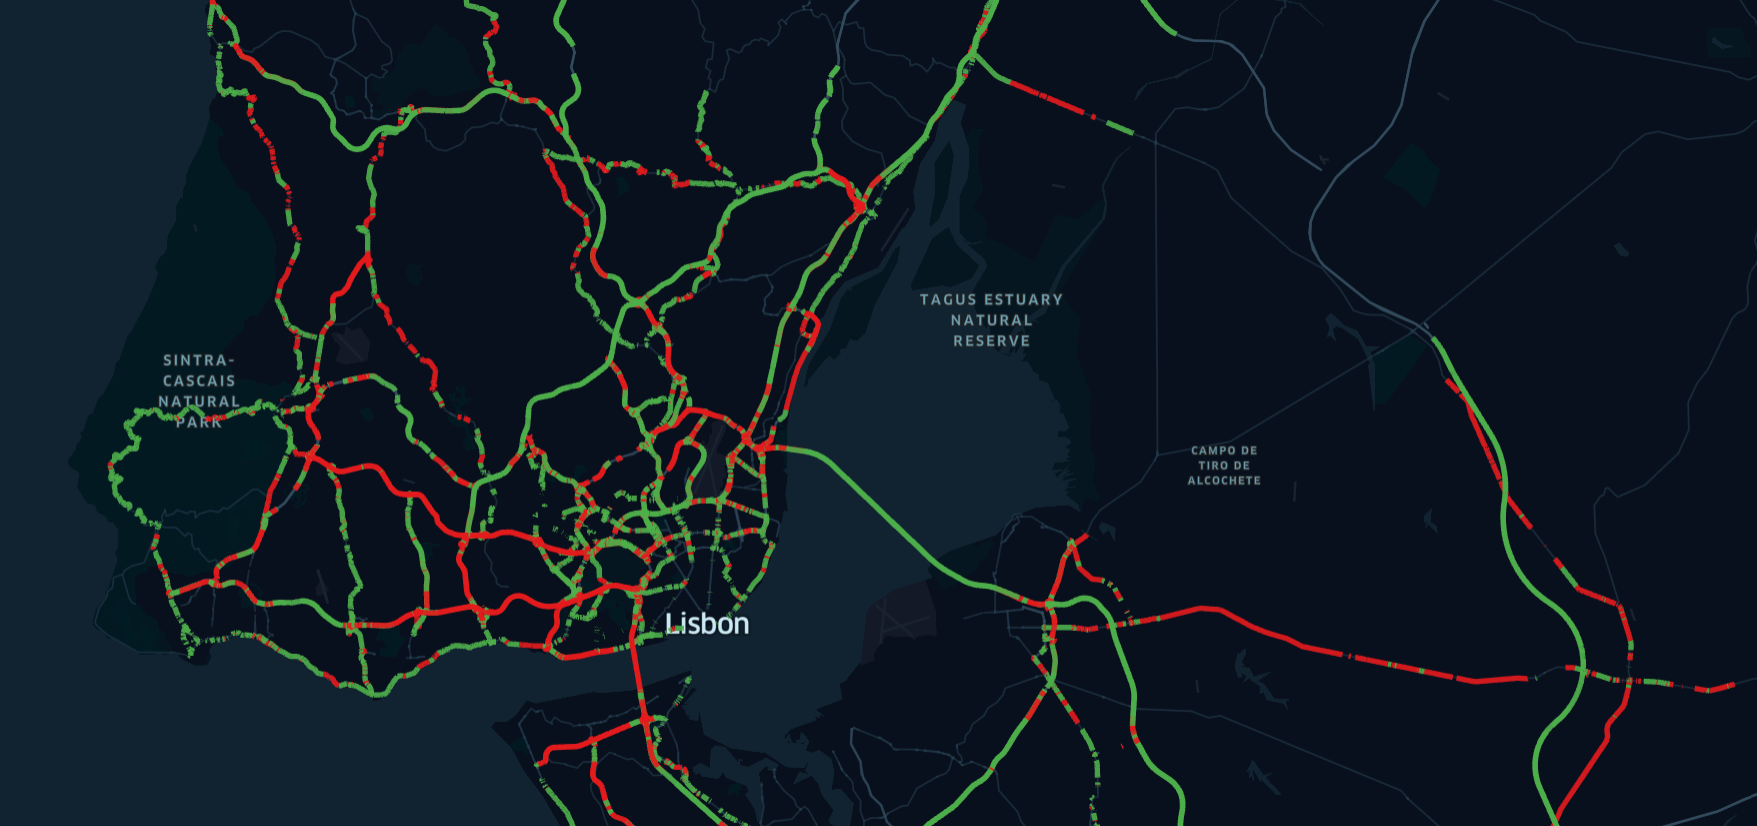

The three more conflictives roads in Porto are:

 - A1 entrance, from Vila Nova da Gaia and Ponte da Arrábida to the junction with A20 rinkroad.
 - The entire A20 north segments, nourished by Maia and Matosinhos. As we see in the first repository these two cities have high afluence to Porto.
 - A43, which allows the entrance to Porto for the east, including Gondomar people, the third top 3 by entrance afluence to Porto.

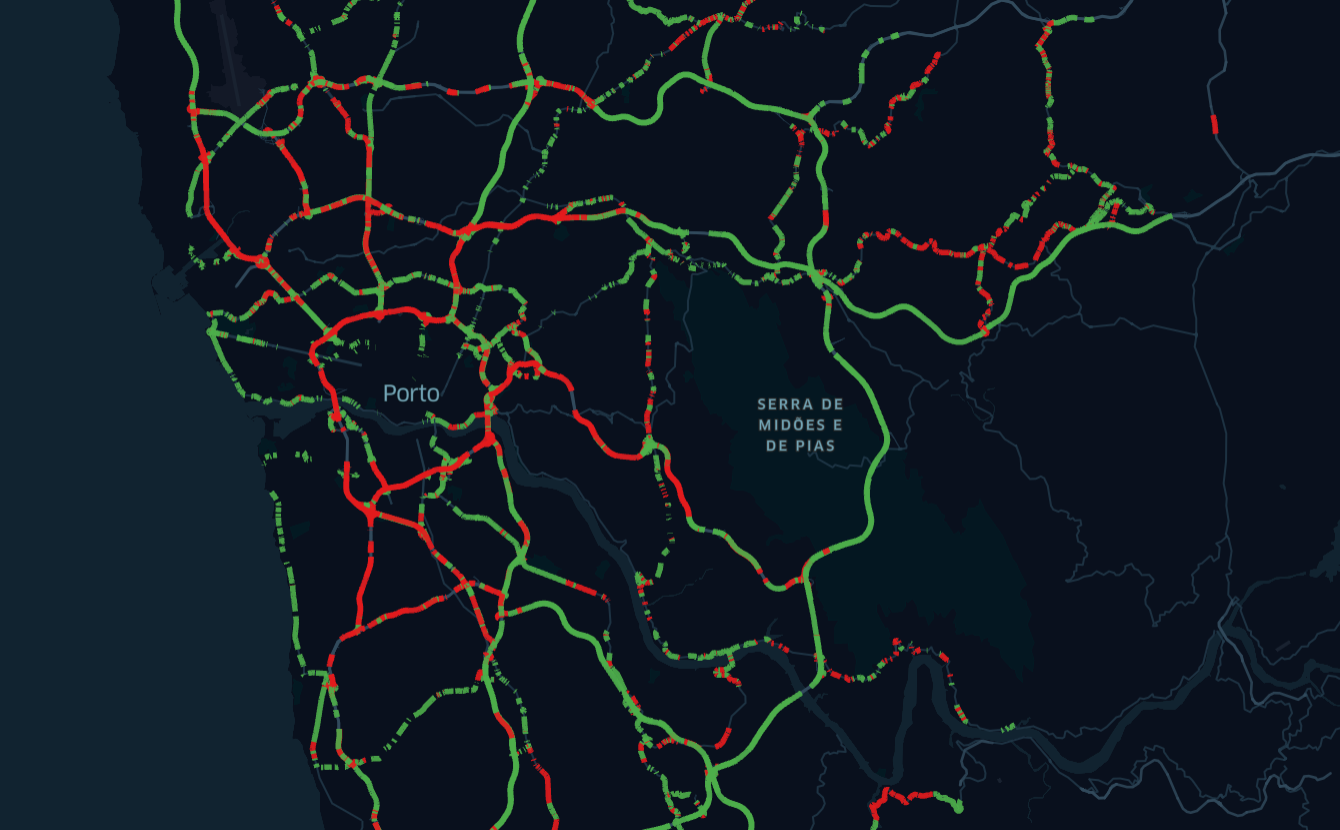

### Radial Chart

To end, we want to show some statistics facing both regions, Lisbon and Porto. We would like to know where the traffic is heavier and where there are more drivers concerned by type of roads and traffic level.

For that, we build the last variable, Super_speed, which indicates if that segment is super fast or super slow. Super fast is defined as every segment which 3th quartile speed is higher than speed limit * 0.9, menawhile Super slow flags when first quartile speed is under speed limit * 0.5 

We will show a radial chart comparing these indicators in both cities:
 - number of drivers by speed lim cat and traffic level segments.
 - number of drivers by super speed segments

It is difficult to relativize the indicators, because we don't know the number of segments by road and their distance (in Km). So, we have standardized by number of daily instensity by segment.



In [ ]:
# We import again the original data to get the geometry in a suitable format
with open('./sample_data/m_risk_prfile.geojson') as f:
 data0 = json.load(f)

data_coord = json_normalize(data0, 'features',['name','crs']).drop(['crs'], axis = 'columns')
data_coord = data_coord.rename(columns = {'properties.Link_ID':'link_id','geometry.coordinates':'segment_coord'})
data_coord = data_coord[['link_id','segment_coord']]

# We divide the dataset by region, Lisboa and Porto
region_ini = []
lat_ini = []
for i in range(len(data_coord.segment_coord)):
  if list(data_coord.segment_coord[i][0][0])[1] <= 41:
    region_ini = region_ini + ['Lisboa']
    lat_ini = lat_ini + [list(data_coord.segment_coord[i][0][0])[1]]
  else:
    region_ini = region_ini + ['Porto']
    lat_ini = lat_ini + [list(data_coord.segment_coord[i][0][0])[1]]
df_region = pd.DataFrame(region_ini).rename(columns = {0:'region'})
data_reg = data_clus.merge(df_lat, right_index = True, left_index = True, how = 'left')

In [182]:
num_driv_Lx = []
num_driv_Prt = []

#data_reg = data_reg[data_reg["speed_1st_qrt"]  ]
data_reg.loc[data_reg["speed_1st_qrt"] <= data_reg["speed_lim"] * 0.5, 'super_speed'] = 'SuperSlow'
data_reg.loc[data_reg["speed_3th_qrt"] >  data_reg["speed_lim"] * 0.9, 'super_speed'] = 'SuperFast'
data_rad_Lx = data_reg[data_reg["region"] == "Lisboa"]
data_rad_Prt = data_reg[data_reg["region"] == "Porto"]

# LISBOA
# Radial by speed_lim_cat and traffic level
Num_driv_spd = data_rad_Lx.groupby(["speed_lim_cat","traffic_level"])["daily_intensity"].agg(['sum','count'])
for i in range(len(Num_driv_spd)):
  num_driv_Lx.append(Num_driv_spd["sum"][i] / Num_driv_spd["count"][i])

# Radial SuperSpeed variable
Num_driv_SS = data_rad_Lx.groupby(["super_speed"])["daily_intensity"].agg(['sum','count'])
for i in range(len(Num_driv_SS)):
  num_driv_Lx.append(Num_driv_SS["sum"][i] / Num_driv_SS["count"][i])


# PORTO
# Radial by speed_lim_cat and traffic level
Num_driv_spd = data_rad_Prt.groupby(["speed_lim_cat","traffic_level"])["daily_intensity"].agg(['sum','count'])
for i in range(len(Num_driv_spd)):
  num_driv_Prt.append(Num_driv_spd["sum"][i] / Num_driv_spd["count"][i])

# Radial SuperSpeed variable
Num_driv_SS = data_rad_Prt.groupby(["super_speed"])["daily_intensity"].agg(['sum','count'])
for i in range(len(Num_driv_SS)):
  num_driv_Prt.append(Num_driv_SS["sum"][i] / Num_driv_SS["count"][i])

variables = ["Num_drivers_by_Fast_segment_high_traffic","Num_drivers_by_Med_segment_high_traffic","Num_drivers_by_Slow_segment_high_traffic",
             "Num_drivers_by_Fast_segment_low_traffic","Num_drivers_by_Med_segment_low_traffic","Num_drivers_by_Slow_segment_low_traffic",
             "Num_drivers_by_SuperSlow_segment","Num_drivers_by_SuperFast_segment"]


In [181]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r = num_driv_Lx, theta = variables, fill='toself', name='Lisboa'))
fig.add_trace(go.Scatterpolar(r = num_driv_Prt, theta = variables, fill='toself', name='Porto'))
fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 5500])),
  showlegend=True
)
fig.show()

Porto wins in number of drivers in high traffic roads in Med and Slow segments. Also in both Super speed segments. The rest of indicators are independent of the region.

The most remarkable conclusion we can obtain from this analysis is that Porto's users are more concentrated. As we see in the table below, Porto has the 41% of the daily drivers, but the 37% of the segments.

In [184]:
Num_driv_spd = data_reg.groupby(["region"])["daily_intensity"].agg(['sum','count'])
Num_driv_spd["%_daily_users"] = 100 * Num_driv_spd["sum"][1] / Num_driv_spd["sum"].sum()
Num_driv_spd["%_segments"] = 100 * Num_driv_spd["count"][1] / Num_driv_spd["count"].sum()
Num_driv_spd[Num_driv_spd.index == "Porto"][["%_daily_users","%_segments"]]

,%_daily_users,%_segments
region,,
Porto,41.269187,37.117095


### Conclusions

### Scalability and Impact

In conclusion, we see there are a lot of segments with high traffic levels. Does not matter the type of road. For both cities, Lisbon and Porto, there are special conflictives areas which need actions to speed up. It is mandatory to change and renew the city transportations. We live in the instantaneous era, not in wasting time era. 

Lisbon and Porto transport behaviour probably are quite similar to the rest of big cities of Europe, the situation we have described and solutions we propose in the entire repository could be scalable to other cities in the continent. In fact, the transformation should be carry out in combination with the closest big cities. 


### Future Work
#### 3 Ways of reducing car number vehicules and optimazing (increasing) the usage of every one.

We find 3 different ways of reducing traffic congestion in cities. Carsharing platforms, temporary bus lines and Lisboa Central Project. Cars would stay less hours "sleeping". By not needing parkings we could get bigger the pedestrian areas or parks, making greener the city centers. These solutions are based in the main suggestions we make to us when we buy a car: "I need it to go everyday to the office" and "What I do without my car when I am in holidays?". 


 - **Carsharing platforms**: They are already implemented in some cities (Lisbon for example). The main advantage these systems give us is the possibility of reducing the number of cars inside the cities. We differenciate two classes of carsharing:
  - Car, moto and bike renting by minutes, this system covers little transportations, which are the most frequents. Through an APP you can rent a vehicule and then some minutes later park it in other city point.
  - By sharing your own car, you could cover long travels or rutinary routes. Expanding this system you could avoid the one-passenger big travels to other cities or towns, even programmate them for the recursive routes.

  
- **Temporary Buslines**: Nowadays there are destinations which are very required but not the entire year. These destiantions are the favourites only few months (Ski stations in winter or beach areas in summer), or a few days (musique festivals, sports and cultural events). For governments and city councils is not profitable to implement bus lines, so when people comes to these destinations theres is not collective transport for them, then they are obligated to use their own cars. 

  However, if an enterprise organises collective transportations by periods, regarding to these social events, people could share transportation vehicules. The usage of these system could work like social networks, people publish their destinations and their transport preferences, then the bus companies and other automotives entities could offer their transport options and tariffs. This solution could be complemented with "Sharing your own car". 


- **Lisboa Central** Taking the baton of "Lisboa 2020 Capital Verde Europeia", we propose a new city transport structure, the "Lisboa Central" project. This project is also useful for Porto.

  The project draw an area in which only residents, electric cars and public transport could pass through. Maximum speed is limited to 50Km/h. With these restrictions we want to reduce dramatically the number of cars running in the center of Lisbon, leaving these spaces to pedestrians and bikers. In order to not stop city activity we propose different communication solutions:
  - Expand the bike lane network, giving priority to bikers face to drivers
  - Install electric car charging points. Nowadays, one reason people does not invest in electric cars is because there are not many charging points. We can install them in restaurants, hospitals, supermarkets...
  
  - Relaunch public transport network, the main congestion situations in the big cities occurs every morning and every afternoon going and coming back from the office. One of the main reasons people use private transport everyday is because the alternative it is not practical.
    
    People from the suburbs are not well connected with their destinations. For exemple people from Odivelas, as we see in the stage1 repository, goes to Alvalade, which is one of the main transport centers of Lisbon, it counts with a big bus network and it is connected with different metro lines, which is really good. But there is a big percentage of people from Odivelas who going to Alvalade is not a practical option, because they have to take another transport. So finally they decide to use their own car. 

    Our proposal is to offer more principal destinations, such as Marques de Pombal or Cais de Sodré, which they also have connections with other transports (metro, tram, bus, ferry...).

    Finally we propose "high ocupation" lane in the main entrance city routes. So people who go in private car every morning is locked up in a bottleneck, meanwhile bus users run faster and they arrive before to their destinations. These lanes, operate in a single direction, in the morning boost the entrance to the city, in the afternoon they assist the exit. 